## Homework 05

### MACS 30100 Perspectives on Computational Modeling, Dr. Soltoff

Ellen Hsieh

11 Feb 2019

### Train a series of models

In [1]:
import pandas as pd
import numpy as np
from random import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load the data
gss_train = pd.read_csv('./data/gss_train.csv')
gss_test = pd.read_csv('./data/gss_test.csv')
gss_local = pd.read_csv('./data/gss_local.csv')

In [3]:
x_train = gss_train.drop(['colrac'], axis=1).values
y_train = gss_train[['colrac']].values
x_test = gss_test.drop(['colrac'], axis=1).values
y_test = gss_test[['colrac']].values

In [4]:
# randomly select 10 differnt hyperparameters for knn
knn_params = []
for i in range(10):
    r = randint(1, 50)
    knn_params.append(r)  

In [5]:
models = []
model_names = []

# Logistic regression model
logit = LogisticRegression()
models.append(logit)
model_names.append('logit')

# Linear discriminant model
lda = LinearDiscriminantAnalysis()
models.append(lda)
model_names.append('lda')

# Quadratic discriminant model
qda = QuadraticDiscriminantAnalysis()
models.append(qda)
model_names.append('qda')

# Naive Bayes
nb = GaussianNB()
models.append(nb)
model_names.append('nb')

# K-nearest neighbors with k = 1~10
for k in knn_params:
    models.append(KNeighborsClassifier(n_neighbors=k))
    model_names.append('knn_{}'.format(k))

### Evaluate their performance

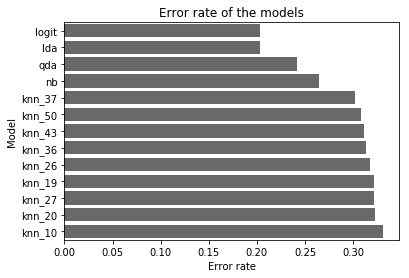

In [6]:
# calculate the error rate of the models
error_rates = [1-np.mean(cross_val_score(model, x_train, y_train, 
                                         cv=KFold(10), scoring='accuracy')) for model in models]
errors_df = pd.DataFrame({'Error rate': error_rates, 'Model': model_names})
ax = sns.barplot(x="Error rate", y="Model", data=errors_df.sort_values(by=['Error rate']), color='dimgrey')
plt.title('Error rate of the models')
plt.show()

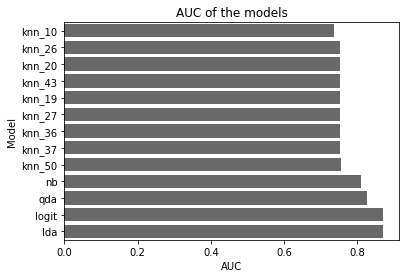

In [7]:
# calcualte the AUC of the models
aucs = [np.mean(cross_val_score(model, x_train, y_train, cv=KFold(10), scoring='roc_auc')) for model in models]
aucs_df = pd.DataFrame({'AUC': aucs, 'Model': model_names})
ax = sns.barplot(x='AUC', y='Model', data=aucs_df.sort_values(by=['AUC']), color='dimgrey')
plt.title('AUC of the models')
plt.show()

After analyzing the error rate and AUC of the models, both logit and LDA perform pretty well(the outcome of error rate and AUC are really close). Although the performances of those two models are nearly no difference, I would choose Logit model, for LDA requires the data to be normally-distributed and share the same covariance matrix.

In [8]:
# fit Logit with trianing data
logit = LogisticRegression().fit(x_train, y_train)
pred_prob = logit.predict_proba(x_test)[:,1]
pred = logit.predict(x_test)
error = 1 - accuracy_score(y_test, pred)
print('Error rate of Logit: {}'.format(error))

Error rate of Logit: 0.2210953346855984


AUC of Logit:0.7738248924197285


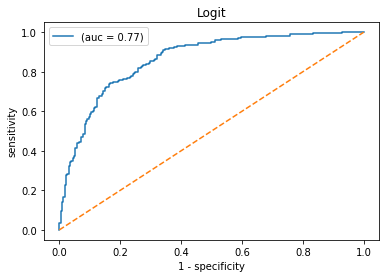

In [9]:
# calculate AUC of Logit model
auc = roc_auc_score(y_test, logit.predict(x_test))
pred_prob = logit.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, pred_prob)

# plot AUC of Logit model
plt.plot(fpr, tpr, label='(auc = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('1 - specificity')
plt.ylabel('sensitivity')
plt.title('Logit')
plt.legend()
print('AUC of Logit:{}'.format(auc))

### Interpret and explain the model 

#### Global explanations

In [10]:
# fit NB with trianing data
nb = GaussianNB().fit(x_train, y_train)

##### 1. Feature importance

In [13]:
from skater.model import InMemoryModel
from skater.core.explanations import Interpretation

# calculate the feature importance
model = InMemoryModel(nb.predict_proba, examples = x_train)
interpreter = Interpretation(x_train)
importance = interpreter.feature_importance.feature_importance(model)

2019-02-11 00:06:45,553 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[55/55] features ████████████████████ Time elapsed: 6 seconds

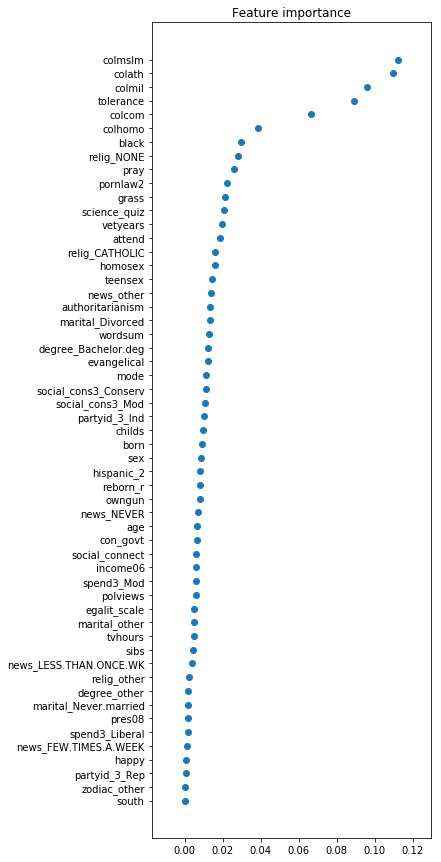

In [14]:
# plot the feature importance
features = np.array(gss_train.drop(['colrac'], axis=1).columns)
plt.figure(figsize=(5,15))
yrange = np.arange(0,len(features))
plt.scatter(importance, yrange)
plt.yticks(yrange, features[importance.index])
plt.title('Feature importance')
plt.show()

From the feature importance figure, we can know that the 5 most important features are 'colmslm', 'colath', 'colmil', 'tolerance', and 'colcom'. 

##### 2. PDPs and ICE

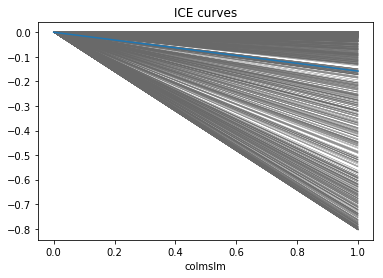

In [15]:
from pycebox.ice import ice, ice_plot

ice_data = gss_train.drop(['colrac'], axis=1)
pred_func = lambda x:nb.predict_proba(x)[:,0]

# plot ICE curves and PDP of colmslm
ice_df = ice(ice_data, 'colmslm', pred_func)
ice_plot(ice_df, c='dimgray', linewidth=0.4, plot_pdp=True, centered=True)
plt.title('ICE curves')
plt.xlabel('colmslm')
plt.show()

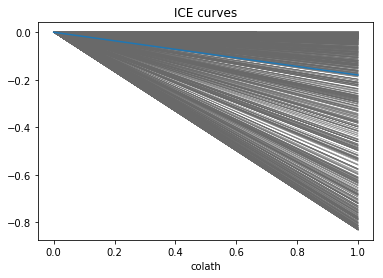

In [16]:
# plot ICE curves and PDP of colath
ice_df = ice(ice_data, 'colath', pred_func)
ice_plot(ice_df,c='dimgray', linewidth=0.5, plot_pdp=True, centered=True)
plt.title('ICE curves')
plt.xlabel('colath')
plt.show()

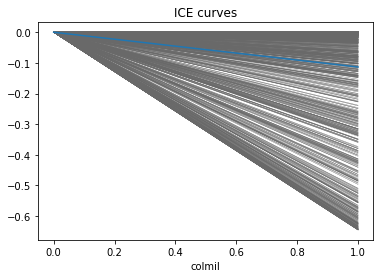

In [17]:
# plot ICE curves and PDP of colmil
ice_df = ice(ice_data, 'colmil', pred_func)
ice_plot(ice_df, c='dimgray', linewidth=0.4, plot_pdp=True, centered=True)
plt.title('ICE curves')
plt.xlabel('colmil')
plt.show()

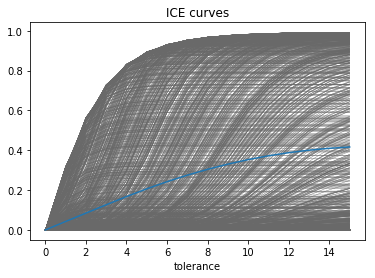

In [18]:
# plot ICE curves and PDP of tolerance
ice_df = ice(ice_data, 'tolerance', pred_func)
ice_plot(ice_df, c='dimgray', linewidth=0.4, plot_pdp=True, centered=True)
plt.title('ICE curves')
plt.xlabel('tolerance')
plt.show()

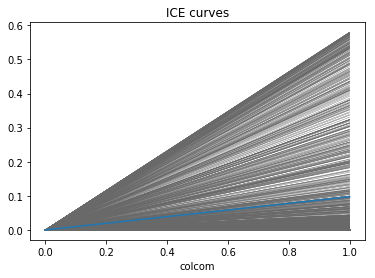

In [19]:
# plot ICE curves and PDP of colcom
ice_df = ice(ice_data, 'colcom', pred_func)
ice_plot(ice_df, c='dimgray', linewidth=0.4, plot_pdp=True, centered=True)
plt.title('ICE curves')
plt.xlabel('colcom')
plt.show()

##### 3. Global surrogate

In [20]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
from skater.util.logger import _INFO

# using only the five most important features to plot the surrogate tree
new_x = ['colath', 'colmslm', 'tolerance', 'colmil', 'colcom']
newx_train = gss_train[new_x].values
new_nb = GaussianNB().fit(newx_train, y_train)

interpreter = Interpretation(newx_train, feature_names=new_x)
model_inst = InMemoryModel(new_nb.predict, examples=newx_train, model_type='classifier', unique_values=[0, 1],
                       feature_names=new_x, target_names=['No','Yes'], log_level=_INFO)

# Using the interpreter instance invoke call to the TreeSurrogate
surrogate_explainer = interpreter.tree_surrogate(oracle=model_inst, seed=5)
surrogate_explainer.fit(newx_train, y_train, use_oracle=True, prune='post', scorer_type='default')
surrogate_explainer.plot_global_decisions(colors=['coral', 'lightsteelblue','darkkhaki'],
                                          file_name='interpretable_tree.png')

2019-02-11 00:11:03,606 - skater.core.global_interpretation.tree_surrogate - INFO - post pruning applied ...
2019-02-11 00:11:03,611 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used f1-score
2019-02-11 00:11:03,615 - skater.core.global_interpretation.tree_surrogate - INFO - original score using base model 1.0
2019-02-11 00:11:03,631 - skater.core.global_interpretation.tree_surrogate - INFO - Summary: childrens of the following nodes are removed [5, 8, 9, 13, 14, 16, 24, 25]
2019-02-11 00:11:03,774 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (1476,)
2019-02-11 00:11:03,778 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 0.991; oracle score 0.769


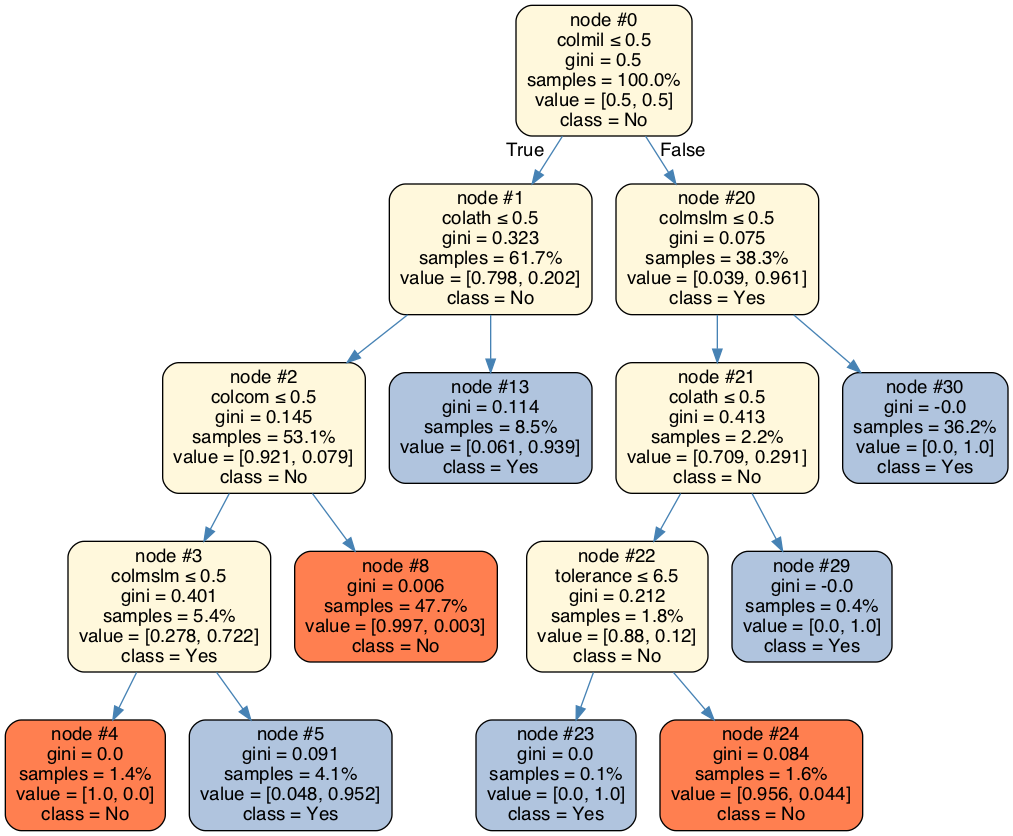

In [21]:
# plot the surrogate tree
from IPython.display import Image
Image(filename = './interpretable_tree.png', width=500, height=500)

#### Local interpretation

In [22]:
import lime
import lime.lime_tabular

# load the local data for 
local = pd.read_csv('./data/gss_local.csv').drop(['colrac'], axis=1)

names = list(gss_train.drop(['colrac'], axis=1).columns)
predict_fn = lambda x:nb.predict_proba(x)

# local surrogate model using the default hyperparameters for lime 
explainer = lime.lime_tabular.LimeTabularExplainer(x_train, feature_names= names, 
                                                   class_names=['No', 'Yes'],  feature_selection='none')

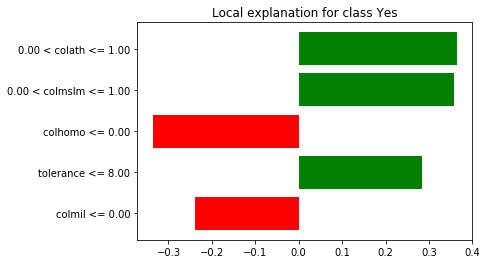

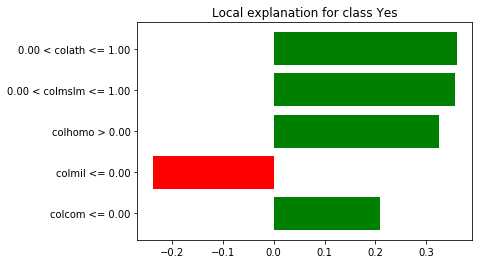

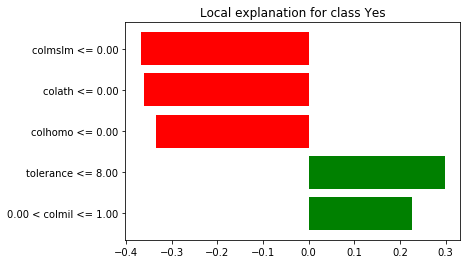

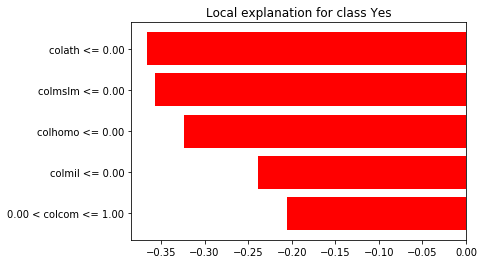

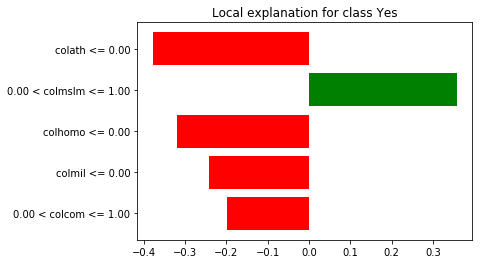

In [32]:
# plot the untuned Lime
for i in range(5):
    explainer.explain_instance(local.loc[i].values, predict_fn, num_features=5).as_pyplot_figure()

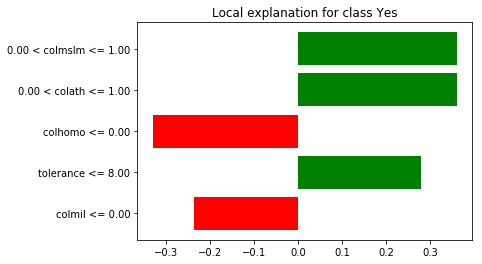

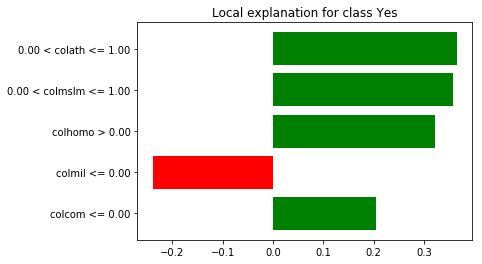

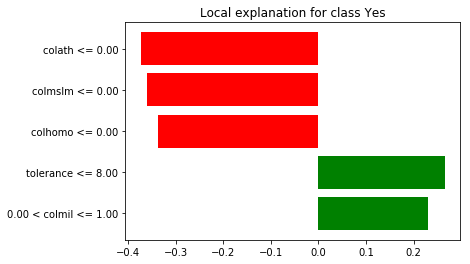

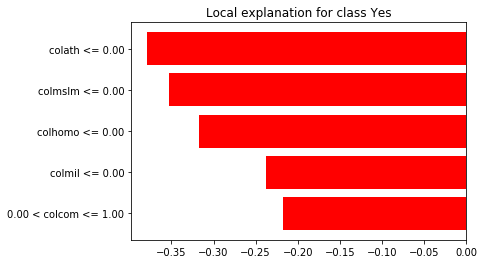

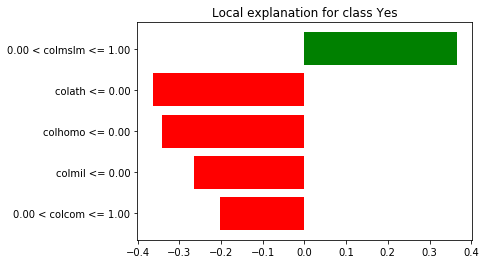

In [31]:
# local surrogate model using auto feature selection
explainer = lime.lime_tabular.LimeTabularExplainer(x_train, feature_names=names, 
                                                   class_names=['No', 'Yes'], feature_selection='auto')
# plot the tuned Lime
for i in range(5):
    explainer.explain_instance(local.loc[i].values, predict_fn, num_features=5).as_pyplot_figure()

For the untuned and tuned Lime, there is no big differences for the 5 most important features, which we can observe from the plots above.